## This is a FSI problem of 2 passive plates linked with spring and damper, oscillating in fluid, however the second spring is totally constrained

In [114]:
using Roots
func(x) = 1/10*(sin(x)+sin(2x)+sin(3x)+sin(4x)+sin(5x)+sin(6x)+sin(7x)+sin(8x)+sin(9x)) - sin(0.1*π)
α₀ = 9*find_zero(func,0.1)

0.6421867650292312

In [115]:
using Revise

using BSON: @save, @load

using Pkg
Pkg.activate("..")
using FSInteraction

In [116]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [117]:
filename = "2dFlag_2body_like_1";

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [118]:
# problem dimension
ndim = 2
# numerical params
tf = 2
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., -1.0, 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 2
# config_body = ConfigBody(nbody)
config_body = ConfigBody(nbody, 4,
    [0. 0.; 1. 0.; 1. 1.0/nbody; 0. 1.0/nbody], 1.5)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
stiff = 0.02
damp = 0.005
config_joints = Vector{ConfigJoint}(undef,njoint)

dof = Dof(3, "passive", stiff, damp, Motions())
dof_hold = Dof(3, "active", stiff, damp, Motions("hold",[0.0]))

config_joints[1] = ConfigJoint(njoint, "revolute",
    [0.,0.,-π/2,1.5,3.0,0.], zeros(Float64,6), 0, [dof], [α₀])

for i = 2:nbody
    config_joints[i] = ConfigJoint(njoint, "revolute", [0., 0., 0., 1.0/njoint, 0., 0.],
        [0., 0., 0., 0., 0., 0.], i-1, [dof_hold], [0.0])
end

#### Build joint-body chain

In [119]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 2 body-joint system, system is fixed in space

#### Initialize rigid body system state to complete body-joint information

In [120]:
bd, soln₀ = InitSystem!(bd);

#### Initialize u and λ container

In [121]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [122]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

In [123]:
# p = plot()
# for i = 1:sys.nbody
#     plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
# end
# plot!(xlims=(0,3), ylims=(0,4), ratio=1, legend=false)

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [124]:
Re = 200 # Reynolds number
U = -1.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, -1.0)

#### Set the domain grid

In [125]:
nx = 152; ny = 202;
Ly = 4.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:3.0100000000000002, -0.01:0.02:4.01)

#### Set up fluid initial conditions

In [126]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Body in fluid plane

In [127]:
plane = [1,2];

#### Genrate body grid points and get linear velocity on them

In [128]:
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx, fine=1))
bgs = CutOut2d(bd,bgs;gap=0.0);

#### Get body points initial coordinates for fluids

In [129]:
bgs = AcquireBodyGridKinematics(bd,bgs);

#### Set up body grid points and force container in fluid

In [130]:
X̃ = BodyGridToVectorData(bgs,"coord";plane=plane)
f = VectorData(X̃);

#### Create fluidstruct structure

In [132]:
tf = 1000Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2

51

## <span style="color:blue"> Create ifherk object </span>

In [133]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys), B₁ᵀ, B₂),
                (M, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx;gap=false,plane=plane),
                 (bd,bgs,u) -> T₂(bd,bgs,u;plane=plane),
                 (bd,bgs) -> getX̃(bd,bgs;plane=plane)),
                ((w,t) -> FSInteraction.r₁(w,t,fsys), F, w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3, rk=TimeMarching.RK31, bodydim=1)

  3.467531 seconds (7.52 M allocations: 816.905 MiB, 3.67% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [134]:
fx = Float64[]
fy = Float64[]
t = 0.0
thist = []
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [135]:
frec = deepcopy(f);
λrec = deepcopy(λ);

In [ ]:
@time for ti in T
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
    frec .= f
    λrec .= λ
    
end

In [142]:
bdhist[end].js[1].vJ

6-element Array{Float64,1}:
  0.0                  
  0.0                  
 -0.016923312233102675 
  0.0                  
  2.144655059658904e-20
  0.0                  

In [143]:
λrec[1:5]

5-element Array{Float64,1}:
  0.005303335629586497
  0.7500082599640041  
  1.5921530071079772  
 -0.012491813432473037
  0.0                 

In [144]:
fx[end]

-0.0016625821720187674

In [145]:
fy[end]

-0.12479664506572313

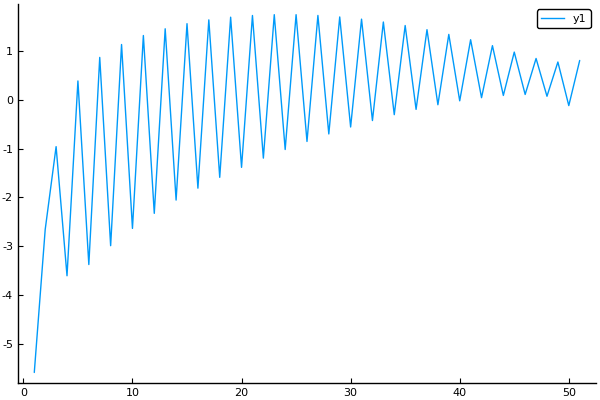

In [146]:
plot(frec.u)

## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [149]:
contour_levels = range(0.5*minimum(w.data),stop=0.5*maximum(w.data),length=50)
sample_rate = 5
fps = 25;

In [150]:
contour_levels = range(-0.5,stop=0.5,length=50)

-0.5:0.02040816326530612:0.5

#### Get body verts history

In [151]:
# get verts info based on this regular grid solution
vshist = []
for i = 1:length(bdhist)
    @get bdhist[i] (bs, js, sys)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field

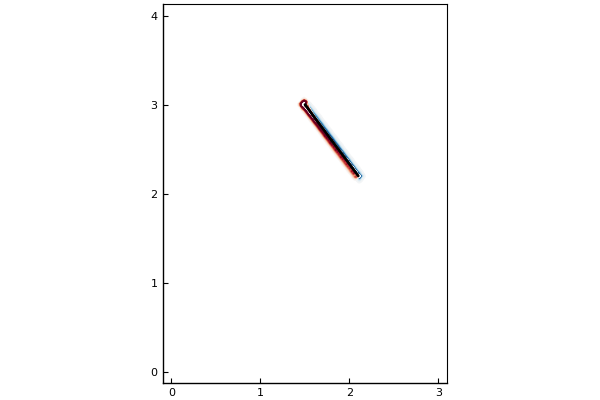

In [152]:
p = plot(xg,yg,whist[1],levels=contour_levels,color=:RdBu_r,clims=(-0.5,0.5))
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black")
end
p

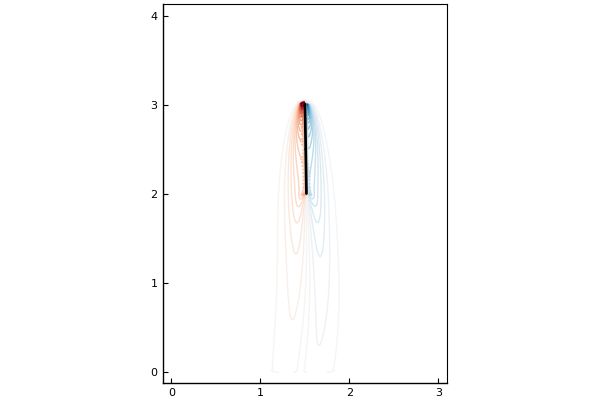

In [154]:
p = plot(xg,yg,whist[end],levels=contour_levels,color=:RdBu_r,clims=(-0.5,0.5))
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="black")
end
# savefig(p,"plate.eps")
p

#### Body position begining and end

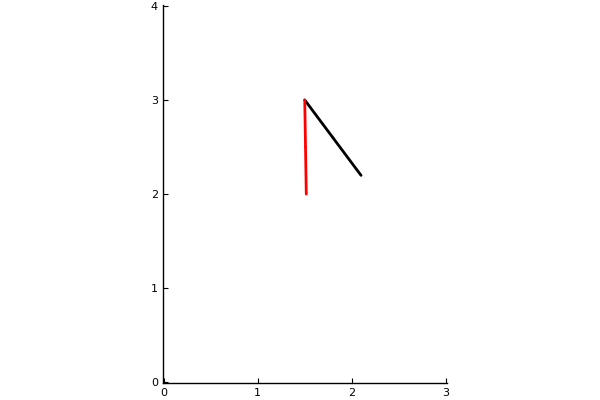

In [156]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black",label="begin")
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="red",label="end")
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]),ratio=1, legend=false)
pb

#### Make gif

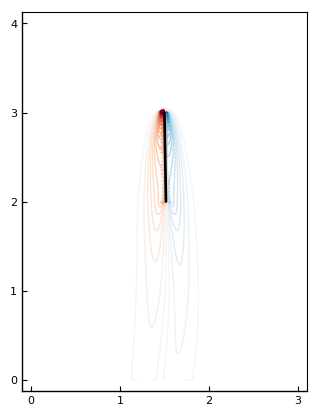

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/tmp/2dFlag_10body_like_1.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/tmp/2dFlag_10body_like_1.gif")

In [157]:
anim = @animate for j = 1:sample_rate:length(whist)
# anim = @animate for j = 1:sample_rate:1200
    plot(xg,yg,whist[j],levels=contour_levels,color=:RdBu_r,clims=(-0.5,0.5))
    for i = 1:sys.nbody
        plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="black")
    end
end

gif(anim, filename*".gif", fps = fps)

#### Tail trajectory

In [165]:
tail_1body = [0.698742, 0.696501, 0.694242, 0.691965, 0.68967, 0.687359, 0.685031, 0.682687, 0.680329, 0.677957, 0.675571, 0.673174, 0.670767, 0.668349, 0.665921, 0.663486, 0.661043, 0.658594, 0.65614, 0.653682, 0.65122, 0.648756, 0.646291, 0.643825, 0.641359, 0.638895, 0.636434, 0.633976, 0.631522, 0.629074, 0.626632, 0.624197, 0.62177, 0.619351, 0.616942, 0.614545, 0.612158, 0.609784, 0.607423, 0.605076, 0.602744, 0.600427, 0.598126, 0.595843, 0.593577, 0.59133, 0.589102, 0.586894, 0.584707, 0.582541, 0.580396, 0.578274, 0.576175, 0.5741, 0.572049, 0.570023, 0.568022, 0.566047, 0.564098, 0.562176, 0.560281, 0.558413, 0.556573, 0.554762, 0.55298, 0.551226, 0.549502, 0.547807, 0.546142, 0.544508, 0.542903, 0.541329, 0.539786, 0.538274, 0.536793, 0.535343, 0.533924, 0.532537, 0.531181, 0.529857, 0.528564, 0.527302, 0.526072, 0.524874, 0.523707, 0.522571, 0.521466, 0.520392, 0.51935, 0.518338, 0.517356, 0.516406, 0.515485, 0.514595, 0.513735, 0.512905, 0.512104, 0.511332, 0.510589, 0.509875, 0.509189, 0.508531, 0.507901, 0.507298, 0.506723, 0.506174, 0.505651, 0.505155, 0.504684, 0.504239, 0.503818, 0.503422, 0.50305, 0.502701, 0.502376, 0.502074, 0.501795, 0.501537, 0.501301, 0.501086, 0.500892, 0.500719, 0.500565, 0.500431, 0.500316, 0.500219, 0.500141, 0.50008, 0.500037, 0.50001, 0.5, 0.500006, 0.500027, 0.500064, 0.500115, 0.50018, 0.500259, 0.500351, 0.500456, 0.500574, 0.500703, 0.500844, 0.500996, 0.501159, 0.501332, 0.501515, 0.501707, 0.501908, 0.502118, 0.502336, 0.502562, 0.502795, 0.503035, 0.503281, 0.503533, 0.503791, 0.504055, 0.504323, 0.504596, 0.504873, 0.505153, 0.505437, 0.505724, 0.506014, 0.506306, 0.506599, 0.506895, 0.507191, 0.507488, 0.507786, 0.508084, 0.508382, 0.508679, 0.508975, 0.509271, 0.509565, 0.509857, 0.510147, 0.510435, 0.510721, 0.511003, 0.511283, 0.511559, 0.511832, 0.5121, 0.512365, 0.512625, 0.512881, 0.513133, 0.513379, 0.51362, 0.513856, 0.514086, 0.514311, 0.514529, 0.514742, 0.514949, 0.515149, 0.515343, 0.515531, 0.515712, 0.515886, 0.516053, 0.516214, 0.516367, 0.516513, 0.516653, 0.516785, 0.516909, 0.517027, 0.517137, 0.517239, 0.517334, 0.517422, 0.517503, 0.517576, 0.517641, 0.517699, 0.51775, 0.517793, 0.51783, 0.517858, 0.51788, 0.517894, 0.517901, 0.517901, 0.517894, 0.51788, 0.517859, 0.517831, 0.517797, 0.517756, 0.517708, 0.517654, 0.517594, 0.517527, 0.517454, 0.517375, 0.51729, 0.517199, 0.517103, 0.517001, 0.516893, 0.516781, 0.516662, 0.516539, 0.516411, 0.516278, 0.51614, 0.515998, 0.515851, 0.5157, 0.515544, 0.515385, 0.515222, 0.515054, 0.514884, 0.514709, 0.514532, 0.514351, 0.514167, 0.51398, 0.51379, 0.513598, 0.513403, 0.513206, 0.513006, 0.512805, 0.512601, 0.512395, 0.512188, 0.51198, 0.511769, 0.511558, 0.511346, 0.511132, 0.510918, 0.510702, 0.510487, 0.510271, 0.510054, 0.509837, 0.50962, 0.509404, 0.509187, 0.508971, 0.508755, 0.508539, 0.508325, 0.508111, 0.507898, 0.507686, 0.507475, 0.507265, 0.507057, 0.50685, 0.506645, 0.506441, 0.506239, 0.506039, 0.505841, 0.505645, 0.505452, 0.50526, 0.505071, 0.504884, 0.5047, 0.504519, 0.50434, 0.504164, 0.503991, 0.503821, 0.503654, 0.50349, 0.50333, 0.503172, 0.503018, 0.502867, 0.50272, 0.502577, 0.502437, 0.5023, 0.502167, 0.502038, 0.501913, 0.501792, 0.501674, 0.501561, 0.501451, 0.501346, 0.501244, 0.501146, 0.501053, 0.500963, 0.500878, 0.500796, 0.500719, 0.500645, 0.500576, 0.500511, 0.50045, 0.500393, 0.500339, 0.50029, 0.500245, 0.500204, 0.500167, 0.500133, 0.500104, 0.500078, 0.500056, 0.500038, 0.500023, 0.500012, 0.500005, 0.500001, 0.5, 0.500003, 0.50001, 0.500019, 0.500032, 0.500048, 0.500068, 0.50009, 0.500115, 0.500143, 0.500174, 0.500208, 0.500244, 0.500283, 0.500325, 0.500369, 0.500415, 0.500464, 0.500515, 0.500568, 0.500623, 0.500681, 0.50074, 0.500801, 0.500863, 0.500928, 0.500994, 0.501061, 0.50113, 0.5012, 0.501272, 0.501345, 0.501418, 0.501493, 0.501569, 0.501645, 0.501723, 0.501801, 0.50188, 0.501959, 0.502039, 0.502119, 0.502199, 0.50228, 0.502361, 0.502442, 0.502523, 0.502603, 0.502684, 0.502765, 0.502845, 0.502925, 0.503005, 0.503084, 0.503162, 0.50324, 0.503318, 0.503394, 0.50347, 0.503545, 0.503619, 0.503692, 0.503765, 0.503836, 0.503906, 0.503975, 0.504042, 0.504109, 0.504174, 0.504238, 0.5043, 0.504362, 0.504421, 0.504479, 0.504536, 0.504591, 0.504644, 0.504696, 0.504746, 0.504795, 0.504842, 0.504887, 0.50493, 0.504971, 0.505011, 0.505049, 0.505085, 0.505119, 0.505152, 0.505182, 0.505211, 0.505237, 0.505262, 0.505285, 0.505306, 0.505325, 0.505342, 0.505357, 0.505371, 0.505382, 0.505391, 0.505399, 0.505404, 0.505408, 0.50541, 0.50541, 0.505408, 0.505404, 0.505398, 0.50539, 0.505381, 0.50537, 0.505357, 0.505342, 0.505326, 0.505307, 0.505287, 0.505266, 0.505243, 0.505218, 0.505191, 0.505163, 0.505133, 0.505102, 0.50507, 0.505036, 0.505, 0.504963, 0.504925, 0.504885, 0.504844, 0.504802, 0.504758, 0.504714, 0.504668, 0.504621, 0.504573, 0.504524, 0.504474, 0.504422, 0.50437, 0.504317, 0.504264, 0.504209, 0.504154, 0.504097, 0.50404, 0.503983, 0.503925, 0.503866, 0.503807, 0.503747, 0.503687, 0.503626, 0.503565, 0.503503, 0.503441, 0.503379, 0.503317, 0.503255, 0.503192, 0.503129, 0.503066, 0.503003, 0.50294, 0.502878, 0.502815, 0.502752, 0.502689, 0.502627, 0.502565, 0.502503, 0.502441, 0.502379, 0.502318, 0.502258, 0.502197, 0.502137, 0.502078, 0.502019, 0.50196, 0.501902, 0.501845, 0.501788, 0.501732, 0.501676, 0.501621, 0.501567, 0.501514, 0.501461, 0.501409, 0.501358, 0.501307, 0.501258, 0.501209, 0.501161, 0.501114, 0.501068, 0.501022, 0.500978, 0.500934, 0.500892, 0.50085, 0.500809, 0.50077, 0.500731, 0.500693, 0.500657, 0.500621, 0.500586, 0.500552, 0.50052, 0.500488, 0.500457, 0.500428, 0.500399, 0.500371, 0.500345, 0.500319, 0.500295, 0.500271, 0.500249, 0.500227, 0.500207, 0.500188, 0.500169, 0.500152, 0.500135, 0.50012, 0.500105, 0.500092, 0.50008, 0.500068, 0.500057, 0.500048, 0.500039, 0.500031, 0.500024, 0.500018, 0.500013, 0.500009, 0.500005, 0.500003, 0.500001, 0.5, 0.5, 0.500001, 0.500002, 0.500004, 0.500007, 0.500011, 0.500015, 0.50002, 0.500025, 0.500032, 0.500039, 0.500046, 0.500054, 0.500063, 0.500072, 0.500082, 0.500092, 0.500103, 0.500114, 0.500126, 0.500138, 0.500151, 0.500164, 0.500177, 0.500191, 0.500205, 0.500219, 0.500234, 0.500249, 0.500264, 0.50028, 0.500295, 0.500311, 0.500327, 0.500344, 0.50036, 0.500377, 0.500394, 0.50041, 0.500427, 0.500444, 0.500461, 0.500478, 0.500496, 0.500513, 0.50053, 0.500547, 0.500564, 0.500581, 0.500598, 0.500614, 0.500631, 0.500647, 0.500664, 0.50068, 0.500696, 0.500712, 0.500728, 0.500743, 0.500759, 0.500774, 0.500789, 0.500803, 0.500817, 0.500832, 0.500845, 0.500859, 0.500872, 0.500885, 0.500897, 0.50091, 0.500922, 0.500933, 0.500944, 0.500955, 0.500966, 0.500976, 0.500986, 0.500995, 0.501004, 0.501013, 0.501021, 0.501029, 0.501036, 0.501043, 0.50105, 0.501056, 0.501062, 0.501067, 0.501072, 0.501077, 0.501081, 0.501085, 0.501088, 0.501091, 0.501094, 0.501096, 0.501098, 0.501099, 0.5011, 0.5011, 0.5011, 0.5011, 0.501099, 0.501098, 0.501096, 0.501095, 0.501092, 0.50109, 0.501087, 0.501083, 0.501079, 0.501075, 0.501071, 0.501066, 0.501061, 0.501055, 0.501049, 0.501043, 0.501037, 0.50103, 0.501023, 0.501015, 0.501007, 0.500999, 0.500991, 0.500983, 0.500974, 0.500965, 0.500955, 0.500946, 0.500936, 0.500926, 0.500916, 0.500905, 0.500895, 0.500884, 0.500873, 0.500862, 0.50085, 0.500839, 0.500827, 0.500815, 0.500803, 0.500791, 0.500779, 0.500767, 0.500754, 0.500742, 0.500729, 0.500716, 0.500704, 0.500691, 0.500678, 0.500665, 0.500652, 0.500639, 0.500626, 0.500614, 0.500601, 0.500588, 0.500575, 0.500562, 0.500549, 0.500536, 0.500523, 0.50051, 0.500498, 0.500485, 0.500472, 0.50046, 0.500447, 0.500435, 0.500423, 0.500411, 0.500399, 0.500387, 0.500375, 0.500363, 0.500352, 0.50034, 0.500329, 0.500318, 0.500307, 0.500296, 0.500285, 0.500275, 0.500264, 0.500254, 0.500244, 0.500234, 0.500224, 0.500215, 0.500206, 0.500197, 0.500188, 0.500179, 0.50017, 0.500162, 0.500154, 0.500146, 0.500138, 0.500131, 0.500123, 0.500116, 0.500109, 0.500103, 0.500096, 0.50009, 0.500084, 0.500078, 0.500073, 0.500067, 0.500062, 0.500057, 0.500052, 0.500048, 0.500044, 0.500039, 0.500036, 0.500032, 0.500028, 0.500025, 0.500022, 0.500019, 0.500017, 0.500014, 0.500012, 0.50001, 0.500008, 0.500007, 0.500005, 0.500004, 0.500003, 0.500002, 0.500001, 0.500001, 0.5, 0.5, 0.5, 0.5, 0.5, 0.500001, 0.500002, 0.500002, 0.500003, 0.500004, 0.500006, 0.500007, 0.500008, 0.50001, 0.500012, 0.500014, 0.500016, 0.500018, 0.50002, 0.500022, 0.500025, 0.500027, 0.50003, 0.500033, 0.500036, 0.500039, 0.500042, 0.500045, 0.500048, 0.500051, 0.500054, 0.500058, 0.500061, 0.500064, 0.500068, 0.500071, 0.500075, 0.500079, 0.500082, 0.500086, 0.50009, 0.500093, 0.500097, 0.500101, 0.500105, 0.500108, 0.500112, 0.500116, 0.50012, 0.500124, 0.500127, 0.500131, 0.500135, 0.500138, 0.500142, 0.500146, 0.500149, 0.500153, 0.500157, 0.50016, 0.500163, 0.500167, 0.50017, 0.500174, 0.500177, 0.50018, 0.500183, 0.500186, 0.500189, 0.500192, 0.500195, 0.500198, 0.500201, 0.500204, 0.500206, 0.500209, 0.500211, 0.500214, 0.500216, 0.500219, 0.500221, 0.500223, 0.500225, 0.500227, 0.500229, 0.50023, 0.500232, 0.500234, 0.500235, 0.500237, 0.500238, 0.500239, 0.50024, 0.500241, 0.500242, 0.500243, 0.500244, 0.500245, 0.500245, 0.500246, 0.500246, 0.500246, 0.500247, 0.500247, 0.500247, 0.500247, 0.500247, 0.500246, 0.500246, 0.500246, 0.500245, 0.500245, 0.500244, 0.500243, 0.500243, 0.500242, 0.500241, 0.50024, 0.500239, 0.500237, 0.500236, 0.500235, 0.500233, 0.500232, 0.50023, 0.500229, 0.500227, 0.500225, 0.500224, 0.500222, 0.50022, 0.500218, 0.500216, 0.500214, 0.500212, 0.500209, 0.500207, 0.500205, 0.500202, 0.5002, 0.500198, 0.500195, 0.500193, 0.50019, 0.500188, 0.500185, 0.500182, 0.50018, 0.500177, 0.500174, 0.500172, 0.500169, 0.500166, 0.500163, 0.50016, 0.500158, 0.500155, 0.500152, 0.500149, 0.500146, 0.500143, 0.50014];

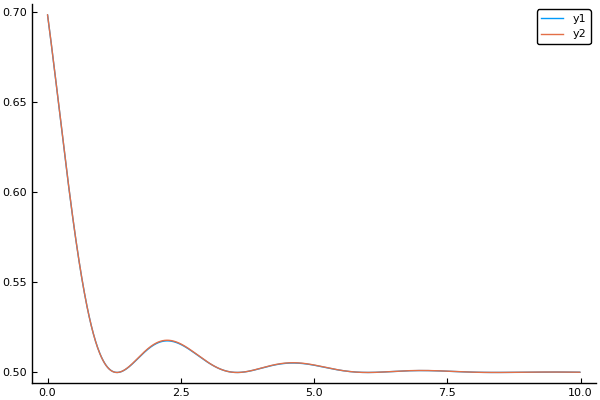

In [166]:
p2hist = []

for i in 1:length(bdhist)
    push!(p2hist,bdhist[i].bs[2].verts_i[3,2]-1.5)    
end

plot(thist,p2hist)
plot!(thist,tail_1body)

#### Force history

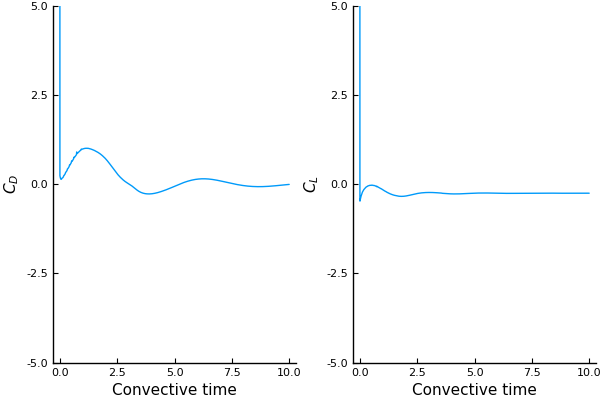

In [161]:
px = plot(thist,2*fx,ylim=(-5,5),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(-5,5),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

## <span style="color:blue"> Save Data </span>

#### Save all current data a .bson file

In [162]:
# @save filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f

#### Use the following block to extract data

In [163]:
# using Dyn3d
# using ViscousFlow

# @load filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f
# @get bd (bs,js,sys);